# Game "Safety" Classification From Game Reviews
by [CSpanias](https://cspanias.github.io/aboutme/), 1st Week's Project for [Solving Business Problems with NLP](https://omdena.com/course/solving-business-problems-with-nlp/) by Omdena

# CONTENT
1. [Webscraping Data](#webscraping)
1. [Functions for Text PreProcessing, Stemming \& Model Evaluation](#functions)
1. [Data Wrangling](#datawrangling)
1. [NLP PipeLine](#pipeline)
    1. [Basic NLP Count-Based Features](#CountBasedFeatures)
    1. [Sentiment Analysis](#sentimentanalysis)
    1. [Term Frequency-Inverse Document Frequency](#tfidf) 
    1. [Logistic Regression](#logreg)
    1. [Random Forest Classifier](#rfc)
        1. [Hyperparameter Tuning](#gs)
1. [Conclusions](#conclusions)

<a name="webscraping"></a>
# 1. Webscraping Data

The data were scraped using __[ParseHub](https://www.parsehub.com/)__, a free & simple tool for web scraping.

Notice that inorder to ensure that the games will have reviews, my __starting URL__ had the games __sorted by Stars: High to Low__ and reviews were __filtered by both Parent & Kids Populatiry__.

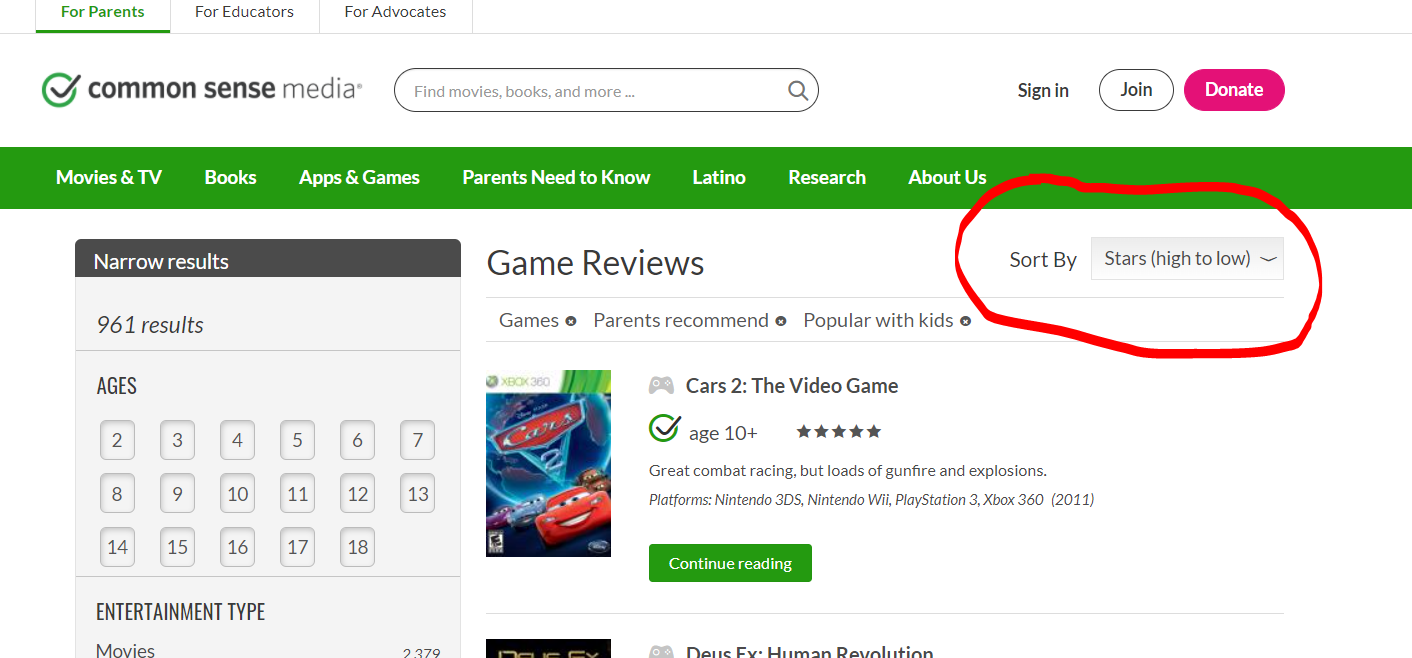

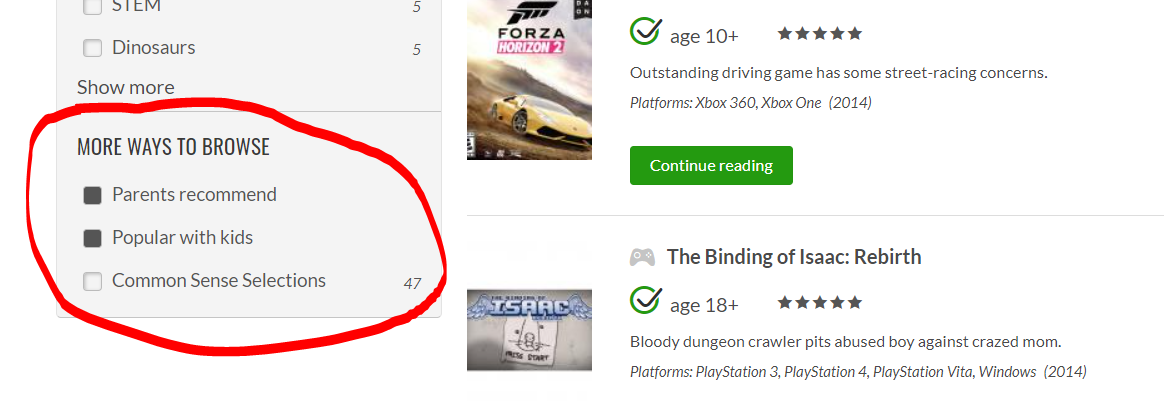

 You can see the __step-by-step commands__ used on the following GIF image.
 
 __Note__: Uncomment and render as markdown cell to see it.

In [65]:
#![parsehub_commands.gif](attachment:parsehub_commands.gif)

<a name="functions"></a>
# 2. Functions for Text Pre-Processing, Stemming & Model Evaluation

First, we have to __import the required libraries__ that we aim to work with.

In [5]:
# import required libraries
import pandas as pd # import dataset, create and manipulate dataframes
import numpy as np # vectorize functions and perform calculations
import contractions # expand contractions
import re # regular expressions
import string # count-based features
import seaborn as sns # visualization
import matplotlib.pyplot as plt # visualization

from pprint import pprint # pretty print
from nltk.tokenize import word_tokenize # tokenize string or sentences
from nltk.stem import PorterStemmer # stemming\
from sklearn.linear_model import LogisticRegression # model
from sklearn.ensemble import RandomForestClassifier # model
from sklearn.feature_extraction.text import TfidfVectorizer # count-based language models
from sklearn.metrics import confusion_matrix, classification_report, make_scorer # model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score # model evaluation metrics
from sklearn.model_selection import GridSearchCV, cross_validate # split & evaluate dataset, hyperparameter optimization
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict # cross-validation
from collections import Counter # count-based calculations
from textblob import TextBlob # sentiment analysis
from wordcloud import WordCloud # visualization
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS # removing stopwords

pd.options.mode.chained_assignment = None  # hide warnings

Secondly, in order to __avoid repetitive code chunks__, we will create some relatively simple functions to user later during our NLP pipeline.

The `normalize_document` function aims to perform some basic text pre-processing tasks in any text document. More specifically:
1. Remove special characters (any characters that are not alphabetic or numeric) using regular expressions.
2. Remove trailing (at the beginning and/or the end) whitespace.
3. Expand contracted words, e.g. `It's` &rarr; `It is`.
4. Tokenize text (split sentences into individual words).
5. Remove stopwords such as the, a, an, etc.
6. Join tokens back into a single string, i.e. like it was first inputted, but "cleaned".

__Note__: A great [article](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a) about the differences of removing stopwords using different libraries (__NLTK__, __spaCy__, __gensim__, __scikit-learn__).

In [8]:
def normalize_document(doc):
    """Normalize the document by performing basic text pre-processing tasks."""
    # remove special characters
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    # remove trailing whitespace
    nowhite = doc.strip()
    # expand contractions
    expanded = contractions.fix(nowhite)
    # tokenize document
    tokens = word_tokenize(expanded)
    # remove stopwords
    filtered_tokens = [token for token in tokens if token not in STOPWORDS]
    # re-create document from tokens
    doc = ' '.join(filtered_tokens)

    return doc

# vectorize function for faster computations
normalize_corpus = np.vectorize(normalize_document)

We will also make a function that performs __stemming__ to a document, that is, removing the word's __affixes__. We will use this function __prior the application of the tfidf process__ (more on this later). 

In [9]:
def simple_text_preprocessor(document):
    """Perform basic text pre-processing tasks."""
    # load up a simple porter stemmer - nothing fancy
    ps = PorterStemmer()

    # lower case
    document = str(document).lower()

    # expand contractions
    document = contractions.fix(document)

    # remove unnecessary characters
    document = re.sub(r'[^a-zA-Z]',r' ', document)
    document = re.sub(r'nbsp', r'', document)
    document = re.sub(' +', ' ', document)

    # simple porter stemming
    document = ' '.join([ps.stem(word) for word in document.split()])

    # stopwords removal
    document = ' '.join([word for word in document.split() if word not in STOPWORDS])

    return document

# vectorize function
stp = np.vectorize(simple_text_preprocessor)

Next we define the `extended_classification_report` which is a function (which I am sure takes a lot of refactoring) that evaluates a model using __cross-validation__, and it is what its name says: an extension of the original __classification report__ from scikit-learn.

In [10]:
def extended_classification_report(model, kf, X, y):
       
    # define scoring metrics
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'neg_brier_score', 'neg_log_loss', 'roc_auc']
    
    # cross-validate model
    model_scores = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=True)

    accuracy_train = []
    accuracy_test = []
    precision_splits = []
    recall_splits = []
    f1_splits = []
    brier_splits = []
    logloss_splits = []
    rocauc_splits = []
    for key, value in model_scores.items():
        if key == 'train_accuracy':
            accuracy_train.append(value)
        if key == 'test_accuracy':
            accuracy_test.append(value)
        if key == 'test_precision':
            precision_splits.append(value)
        if key == 'test_recall':
            recall_splits.append(value)
        if key == 'test_f1':
            f1_splits.append(value)
        if key == 'test_neg_brier_score':
            brier_splits.append(value)
        if key == 'test_neg_log_loss':
            logloss_splits.append(value)
        if key == 'test_roc_auc':
            rocauc_splits.append(value)


    # set column names
    split_cols_names = ['split 1', 'split 2', 'split 3', 'split 4', 'split 5',
                        'split 6', 'split 7', 'split 8', 'split 9', 'split 10']

    # convert lists of scores to dataframe
    accuracy_train = pd.DataFrame(accuracy_train, columns=split_cols_names )
    accuracy_test = pd.DataFrame(accuracy_test, columns=split_cols_names)
    precision_splits = pd.DataFrame(precision_splits, columns=split_cols_names)
    recall_splits = pd.DataFrame(recall_splits, columns=split_cols_names)
    f1_splits = pd.DataFrame(f1_splits, columns=split_cols_names)
    brier_splits = pd.DataFrame(brier_splits, columns=split_cols_names)
    logloss_splits = pd.DataFrame(logloss_splits, columns=split_cols_names)
    rocauc_splits = pd.DataFrame(rocauc_splits, columns=split_cols_names)

    # rename rows
    accuracy_train.rename(index = {0: "Accuracy Train"}, inplace=True)
    accuracy_test.rename(index = {0: "Accuracy Test"}, inplace=True)
    precision_splits.rename(index = {0: "Precision"}, inplace = True)
    recall_splits.rename(index = {0: "Recall"}, inplace = True)
    f1_splits.rename(index = {0: "F1"}, inplace = True)
    brier_splits.rename(index = {0: "Brier"}, inplace = True)
    logloss_splits.rename(index = {0: "LogLoss"}, inplace = True)
    rocauc_splits.rename(index = {0: "RocAuc"}, inplace = True)


    # merge all dataframes into a single one
    metrics_model = pd.concat([accuracy_train, accuracy_test, precision_splits, recall_splits, f1_splits,
                         brier_splits, logloss_splits, rocauc_splits])

    # calculate mean scores for each row
    mean_scores = metrics_model.mean(axis=1)

    # append column to the dataframe
    metrics_model['mean'] = round(mean_scores, 4)
    
    # display dataframe as a table
    return display(metrics_model)

Lastly, we define a short-function `generate_confusion_matrix` for visualizing our results.

In [12]:
def generate_confusion_matrix(y, y_pred):
    """Generate a confusion matrix based on a seaborn heatmap."""
    cm = confusion_matrix(y, y_pred)
    # visualize confusion matrix with seaborn heatmap
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                               'Actual Negative:0'],
                            index=['Predict Positive:1', 'Predict Negative:0'])
    fig, ax = plt.subplots(figsize=(7,7))  
    return sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

<a name="datawrangling"></a>
# 2. Data Wrangling

In [13]:
# import dataset
df = pd.read_csv('https://raw.githubusercontent.com/CSpanias/nlp_resources/main/nlp_omdena/w1/game_data.csv')

In [14]:
# inspect first 5 rows
df.head()

,game_title_name,game_title_game_age,game_title_kid_review_name,game_title_parent_review_name
0,God of War (2018),age 17+,While God of War used to be an ultra-violent a...,NaN
1,God of War (2018),age 17+,"Gone are the days of Kratos over the top, cart...",NaN
2,God of War (2018),age 17+,NOT AS BAD AS PREVIOUS GOD OF WARS. The violen...,NaN
3,God of War (2018),age 17+,Very good story and gameplay,NaN
4,God of War (2018),age 17+,God of War takes a huge risk by completely res...,NaN


We can see that the __column names are unecessary long__, thus, it seems like a good idea to rename them.

In [15]:
# check column names
print(df.columns)

# rename columns
df.rename(columns={
    'game_title_name': 'title',
    'game_title_game_age': 'age',
    'game_title_kid_review_name': 'review_kid',
    'game_title_parent_review_name': 'review_parent'
}, inplace=True)

# check first 5 rows
df.head()

Index(['game_title_name', 'game_title_game_age', 'game_title_kid_review_name',
       'game_title_parent_review_name'],
      dtype='object')


,title,age,review_kid,review_parent
0,God of War (2018),age 17+,While God of War used to be an ultra-violent a...,NaN
1,God of War (2018),age 17+,"Gone are the days of Kratos over the top, cart...",NaN
2,God of War (2018),age 17+,NOT AS BAD AS PREVIOUS GOD OF WARS. The violen...,NaN
3,God of War (2018),age 17+,Very good story and gameplay,NaN
4,God of War (2018),age 17+,God of War takes a huge risk by completely res...,NaN


In [16]:
# check basic stats
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          306 non-null    object
 1   age            306 non-null    object
 2   review_kid     304 non-null    object
 3   review_parent  304 non-null    object
dtypes: object(4)
memory usage: 19.2+ KB


In [17]:
# check for duplicates
print("Number of duplicated rows: {}.".format(df.duplicated().sum()))

Number of duplicated rows: 2.


In [18]:
# drop duplicated rows
df.drop_duplicates(keep='first', inplace=True)

# check duplicates
print("Number of duplicated rows: {}.".format(df.duplicated().sum()))

Number of duplicated rows: 0.


The age column, which will form the base for our classification includes symbols `+`, whitespace, as well as the string `age`.

We will __clean that up using a regular expression__ and extract only what is relevant to us, i.e. the numeric characters.

We will also __replace `NaN` values with an emtpy string__ and then __convert the column to numeric__.

In [19]:
# clean age column
df.age = df.age.str.replace(pat=r'[^\d{,2}]', repl='', regex=True)

#check 1st 5 rows
df.head()

,title,age,review_kid,review_parent
0,God of War (2018),17,While God of War used to be an ultra-violent a...,NaN
1,God of War (2018),17,"Gone are the days of Kratos over the top, cart...",NaN
2,God of War (2018),17,NOT AS BAD AS PREVIOUS GOD OF WARS. The violen...,NaN
3,God of War (2018),17,Very good story and gameplay,NaN
4,God of War (2018),17,God of War takes a huge risk by completely res...,NaN


In [20]:
# replace NaN values
df.replace(np.nan,'',regex=True, inplace=True)
df.head()

,title,age,review_kid,review_parent
0,God of War (2018),17,While God of War used to be an ultra-violent a...,
1,God of War (2018),17,"Gone are the days of Kratos over the top, cart...",
2,God of War (2018),17,NOT AS BAD AS PREVIOUS GOD OF WARS. The violen...,
3,God of War (2018),17,Very good story and gameplay,
4,God of War (2018),17,God of War takes a huge risk by completely res...,


In [21]:
# convert age column to int
df.age = pd.to_numeric(df.age)

# check dtype of age
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608 entries, 0 to 609
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          608 non-null    object 
 1   age            305 non-null    float64
 2   review_kid     608 non-null    object 
 3   review_parent  608 non-null    object 
dtypes: float64(1), object(3)
memory usage: 23.8+ KB


We are not interested in seperating the kids' from parents' reviews in this project, thus, we will __concatenate the two in a single column__.

In [22]:
# merge reviews into 1 column
df['reviews'] = df.review_kid + df.review_parent

# discard unecessary columns
df.drop(columns=['review_kid', 'review_parent'], inplace=True)

# check 1st five rows
df.head()

,title,age,reviews
0,God of War (2018),17.0,While God of War used to be an ultra-violent a...
1,God of War (2018),17.0,"Gone are the days of Kratos over the top, cart..."
2,God of War (2018),17.0,NOT AS BAD AS PREVIOUS GOD OF WARS. The violen...
3,God of War (2018),17.0,Very good story and gameplay
4,God of War (2018),17.0,God of War takes a huge risk by completely res...


In [23]:
# make every review lower-case
df['reviews'] = df['reviews'].apply(str.lower)

# check first 5 rows
df.head()

,title,age,reviews
0,God of War (2018),17.0,while god of war used to be an ultra-violent a...
1,God of War (2018),17.0,"gone are the days of kratos over the top, cart..."
2,God of War (2018),17.0,not as bad as previous god of wars. the violen...
3,God of War (2018),17.0,very good story and gameplay
4,God of War (2018),17.0,god of war takes a huge risk by completely res...


In [24]:
# check missing values
df.isna().sum()

title        0
age        303
reviews      0
dtype: int64

As we can see there are __303 missing values__ in the age column.

We will fill those with __the forward fill method__, as our missing values refer to the movie before them, hence, they have the same age as the cell before them.

In [26]:
# forwardfill missing values
df.fillna(method='ffill', axis=None, inplace=True)

# check for NaNs
df.isna().sum()

title      0
age        0
reviews    0
dtype: int64

Now, we will create our target column based on age:
* If the game has an `age 17+` sign, we want to classify this as `non-safe` and label it as `0`, otherwise we will classify it as `safe` and label it as `1`.


In [27]:
# create category of interest, 1 = safe, 0 = non-safe
df['safe'] = df.apply(lambda row: 1 if row['age'] < 17  else 0, axis=1)

# check 1st five rows
df.head()

,title,age,reviews,safe
0,God of War (2018),17.0,while god of war used to be an ultra-violent a...,0
1,God of War (2018),17.0,"gone are the days of kratos over the top, cart...",0
2,God of War (2018),17.0,not as bad as previous god of wars. the violen...,0
3,God of War (2018),17.0,very good story and gameplay,0
4,God of War (2018),17.0,god of war takes a huge risk by completely res...,0


SInce we have our target column, we don't really need `age` anymore (and we never needed `title` to begin with!).

In [28]:
# discard unecessary columns
df.drop(columns=['title', 'age'], inplace=True)

In [29]:
# check values
print("The target distribution is {} safe (1) and {} non-safe (0) movie titles."
      .format(df.safe.value_counts()[0], df.safe.value_counts()[1]))

The target distribution is 306 safe (1) and 302 non-safe (0) movie titles.


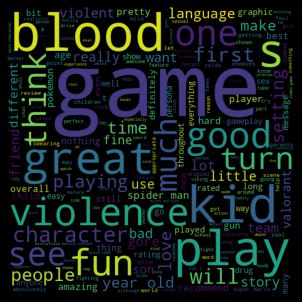

In [30]:
# generate a wordcloud for safe titles
safe_wordcloud = WordCloud(width=512, height=512).generate(' '.join(df['reviews'][df['safe']==1]))
plt.figure(figsize=(6, 4), facecolor='k')
plt.imshow(safe_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

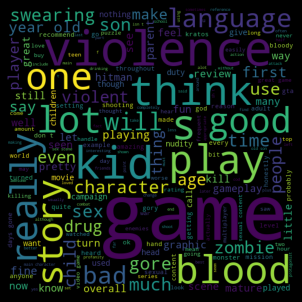

In [31]:
# generate a wordcloud for non-safe titles
non_safe_wordcloud = WordCloud(width=512, height=512).generate(' '.join(df['reviews'][df['safe']==0]))
plt.figure(figsize=(6, 4), facecolor='k')
plt.imshow(non_safe_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [33]:
# normalize 'reviews' column
norm_corpus = normalize_corpus(list(df['reviews']))

In [34]:
# check shape
print("The 'review' column has {} rows.\n".format(df.reviews.shape[0]))

# check first 5 rows
print("The first 5 reviews are:\n{}\n\n".format(df.reviews.head()))

The 'review' column has 608 rows.

The first 5 reviews are:
0    while god of war used to be an ultra-violent a...
1    gone are the days of kratos over the top, cart...
2    not as bad as previous god of wars. the violen...
3                         very good story and gameplay
4    god of war takes a huge risk by completely res...
Name: reviews, dtype: object




In [35]:
# assign feature & target variables
X = df.drop(['safe'], axis = 1)
y = df['safe']

# check shape of features & target sets
print("Features' set shape: {} | Target's set shape {}."
      .format(X.shape, y.shape))

Features' set shape: (608, 1) | Target's set shape (608,).


# 3. NLP Pipeline

<a name="CountBasedFeatures"></a>
## 3.1 Basic NLP Count-Based Features

A number of basic text based features can also be created which sometimes are helpful for **improving text classification models**. 

Some examples are:

- __Word Count:__ total number of words in the documents
- __Character Count:__ total number of characters in the documents
- __Average Word Density:__ average length of the words used in the documents
- __Puncutation Count:__ total number of punctuation marks in the documents
- __Upper Case Count:__ total number of upper count words in the documents
- __Title Word Count:__ total number of proper case (title) words in the documents

Since we chose to __lower-case our reviews__ during the text preprocessing step, we won't need the __upper-case__ & __title-case__ word count features.

**Note**: The aforementioned information comes from [this](https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/) article.

In [36]:
# calculate total number of characters
X['char_count'] = X['reviews'].apply(len)
# calculate total number of words
X['word_count'] = X['reviews'].apply(lambda x: len(x.split()))
# # calculate average word density
X['word_density'] = X['char_count'] / (X['word_count']+1)
# calculate total number of punctuaction marks
X['punctuation_count'] = X['reviews'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

In [37]:
# check df
X.head()

,reviews,char_count,word_count,word_density,punctuation_count
0,while god of war used to be an ultra-violent a...,733,134,5.429630,25
1,"gone are the days of kratos over the top, cart...",3438,600,5.720466,80
2,not as bad as previous god of wars. the violen...,557,108,5.110092,14
3,very good story and gameplay,28,5,4.666667,0
4,god of war takes a huge risk by completely res...,340,62,5.396825,7


<a name="sentimentanalysis"></a>
## 3.2 Sentiment Analysis

We want to **infer safety from game reviews** which are higly **subjective**, **opinionated** and people often **express strong emotions** and **feelings** through it. 

This makes it a classic case where the text documents here are a good candidate for **extracting sentiment as a feature**.

The general expectation is that a **"safe" review** (label 1) should have a **positive sentiment** and a **"non-safe" review** (label 0) should have a **negative sentiment**.

**`TextBlob`** is an excellent open-source library for performing **sentiment analysis** based on a **sentiment lexicon** which leverages to give both **polarity and subjectivity scores**. 

- The **polarity score** is a float within the range [-1.0, 1.0]. 
- The **subjectivity** is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. 

This is **unsupervised**, **lexicon-based sentiment analysis** where **we don't have any pre-labeled data** saying which review migth have a positive or negative sentiment. 

**Note**:The above information come from [this](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72) article.

In [38]:
# calculate review's sentiment 
x_snt_obj = X['reviews'].apply(lambda row: TextBlob(row).sentiment)
# create a column for polarity scores
X['Polarity'] = [obj.polarity for obj in x_snt_obj.values]
# create a column for subjectivity scores
X['Subjectivity'] = [obj.subjectivity for obj in x_snt_obj.values]

In [39]:
# check df
X.head()

,reviews,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity
0,while god of war used to be an ultra-violent a...,733,134,5.429630,25,-0.135732,0.467551
1,"gone are the days of kratos over the top, cart...",3438,600,5.720466,80,0.158171,0.447169
2,not as bad as previous god of wars. the violen...,557,108,5.110092,14,0.057265,0.570391
3,very good story and gameplay,28,5,4.666667,0,0.910000,0.780000
4,god of war takes a huge risk by completely res...,340,62,5.396825,7,0.043074,0.410823


In [40]:
# create a new column with cleaned text
X['clean_reviews'] = stp(X['reviews'].values)

# check first 5 rows
X.head()

,reviews,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity,clean_reviews
0,while god of war used to be an ultra-violent a...,733,134,5.429630,25,-0.135732,0.467551,god war use ultra violent gori video game seri...
1,"gone are the days of kratos over the top, cart...",3438,600,5.720466,80,0.158171,0.447169,gone day krato cartoonish anger issu gratuit v...
2,not as bad as previous god of wars. the violen...,557,108,5.110092,14,0.057265,0.570391,bad previou god war violenc tone consider gut ...
3,very good story and gameplay,28,5,4.666667,0,0.910000,0.780000,veri good stori gameplay
4,god of war takes a huge risk by completely res...,340,62,5.396825,7,0.043074,0.410823,god war huge risk complet reshap formula ha de...


In [41]:
# remove the 2 columns
X_metadata = X.drop(['reviews', 'clean_reviews'], axis=1).reset_index(drop=True)

# check first 5 rows
X_metadata.head()

,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity
0,733,134,5.429630,25,-0.135732,0.467551
1,3438,600,5.720466,80,0.158171,0.447169
2,557,108,5.110092,14,0.057265,0.570391
3,28,5,4.666667,0,0.910000,0.780000
4,340,62,5.396825,7,0.043074,0.410823


<a name="tfidf"></a>
## 3.3 Term Frequency-Inverse Document Frequency

__Term Frequency-Inverse Document Frequency__ (tf-idf) uses a combination of two metrics in
its computation, namely: __term frequency__ (tf) and __inverse document frequency__ (idf). 

This technique was developed for ranking results for queries in search engines and now it is an indispensable model in the world of __information retrieval__ and NLP.

__Note__: More information about [__tfidf__](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a).

In [42]:
# instatiate vectorizer
tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))

# fit vectorizer to 'Clean Review' and convert it to numpy array
X_tv = tv.fit_transform(X['clean_reviews']).toarray()
# create a pandas DataFrame
X_tv = pd.DataFrame(X_tv, columns=tv.get_feature_names())

# check first 5 rows
X_tv.head()

,abbi,abil,abl,abov,absolut,abyss,accept,access,accident,accomplish,...,yo,york,young,younger,youtu,youtub,yr,yukiko,zelda,zombi
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.042861,0.0,0.0,0.0,0.0,0.0,0.099201,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we will __concatenate the two dataframes__, the one that hold __reviews metadata__ and the one with the __tfidf scores__, into one.

In [43]:
# concatenate the 2 dataframes
X_comb = pd.concat([X_metadata, X_tv], axis=1)

# check first 5 rows
X_comb.head()

,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity,abbi,abil,abl,abov,...,yo,york,young,younger,youtu,youtub,yr,yukiko,zelda,zombi
0,733,134,5.429630,25,-0.135732,0.467551,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3438,600,5.720466,80,0.158171,0.447169,0.0,0.042861,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,557,108,5.110092,14,0.057265,0.570391,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28,5,4.666667,0,0.910000,0.780000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,340,62,5.396825,7,0.043074,0.410823,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a name="logreg"></a>
## 3.4 Logistic Regression

In [44]:
# instantiate log reg
lr = LogisticRegression(C=1, random_state=42, solver='liblinear')

# choose how many train/test sets we want by "n_splits"
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# evaluate model
extended_classification_report(model=lr, kf=kfold, X=X_comb, y=y)

,split 1,split 2,split 3,split 4,split 5,split 6,split 7,split 8,split 9,split 10,mean
Accuracy Train,0.970750,0.970750,0.974406,0.976234,0.974406,0.981718,0.974406,0.972578,0.979927,0.972628,0.9748
Accuracy Test,0.868852,0.934426,0.836066,0.885246,0.901639,0.934426,0.901639,0.885246,0.883333,0.850000,0.8881
Precision,0.843750,0.933333,0.812500,0.848485,0.875000,0.964286,0.903226,0.900000,0.925926,0.818182,0.8825
Recall,0.900000,0.933333,0.866667,0.933333,0.933333,0.900000,0.903226,0.870968,0.833333,0.900000,0.8974
F1,0.870968,0.933333,0.838710,0.888889,0.903226,0.931034,0.903226,0.885246,0.877193,0.857143,0.8889
Brier,-0.127148,-0.126270,-0.136914,-0.135501,-0.111976,-0.127439,-0.131835,-0.146346,-0.142211,-0.136818,-0.1322
LogLoss,-0.426779,-0.428614,-0.445304,-0.444204,-0.390733,-0.428997,-0.436492,-0.471081,-0.462463,-0.448915,-0.4384
RocAuc,0.952688,0.991398,0.947312,0.946237,0.988172,0.965591,0.953763,0.956989,0.954444,0.951111,0.9608


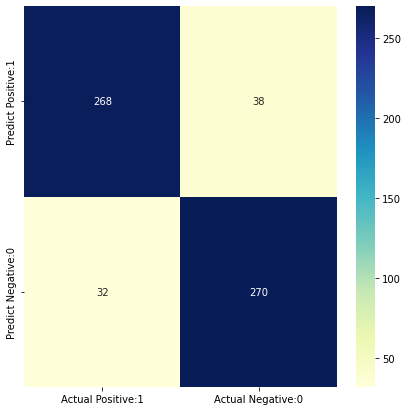

In [45]:
# predict using cv
y_pred = cross_val_predict(lr, X_comb, y, cv=kfold)

# generate cm
generate_confusion_matrix(y=y, y_pred=y_pred);

<a name="rfc"></a>
## 3.5 Random Forest Classifier

In [46]:
# instantiate model
rfc = RandomForestClassifier()

# evaluate model
extended_classification_report(model=rfc, kf=kfold, X=X_comb, y=y);

,split 1,split 2,split 3,split 4,split 5,split 6,split 7,split 8,split 9,split 10,mean
Accuracy Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000
Accuracy Test,1.000000,1.000000,1.000000,0.934426,0.967213,0.967213,0.967213,0.934426,1.000000,0.966667,0.9737
Precision,1.000000,1.000000,1.000000,0.933333,0.937500,0.937500,0.939394,0.935484,1.000000,0.937500,0.9621
Recall,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000,0.935484,1.000000,1.000000,0.9869
F1,1.000000,1.000000,1.000000,0.933333,0.967742,0.967742,0.968750,0.935484,1.000000,0.967742,0.9741
Brier,-0.037456,-0.041546,-0.042293,-0.057620,-0.045408,-0.042590,-0.048061,-0.051587,-0.035308,-0.043810,-0.0446
LogLoss,-0.194764,-0.208242,-0.205972,-0.240833,-0.213435,-0.202642,-0.221137,-0.223380,-0.189471,-0.204037,-0.2104
RocAuc,1.000000,1.000000,1.000000,0.984946,1.000000,1.000000,1.000000,0.995699,1.000000,0.995556,0.9976


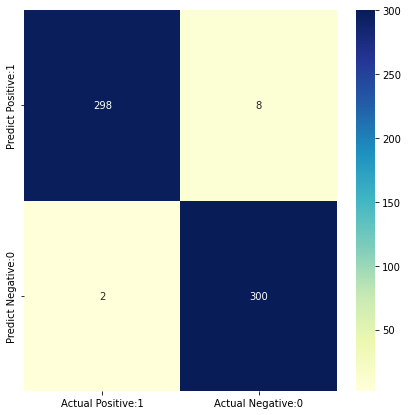

In [47]:
# predict using cv
y_pred = cross_val_predict(rfc, X_comb, y, cv=kfold)

# generate cm
generate_confusion_matrix(y=y, y_pred=y_pred);

<a name="gs"></a>
## 3.5.1 Hyperparameter Tuning

__Note__: Details about how to Tune an RF model in this [article](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).

In [48]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [59]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20, 40, 60, 80, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10, 15, 100],
    'n_estimators': [100, 250, 500, 750, 1000, 1200]
}

# choose how many train/test sets we want by "n_splits"
kfold = StratifiedKFold(n_splits=3, shuffle=True)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 3)

# Fit the grid search to the data
grid_search.fit(X_comb, y)

Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [5, 10, 20, 40, 60, 80, 100],
                         'max_features': [2, 3],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15, 100],
                         'n_estimators': [100, 250, 500, 750, 1000, 1200]},
             verbose=3)

In [63]:
# check best parameters
print("Parameters suggested by GS:\n\n{}".format(grid_search.best_params_))

# instantiate model with best params
best_grid = grid_search.best_estimator_

Parameters suggested by GS:

{'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


In [62]:
# choose how many train/test sets we want by "n_splits"
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# evaluate model
extended_classification_report(model=best_grid, kf=kfold, X=X_comb, y=y)

,split 1,split 2,split 3,split 4,split 5,split 6,split 7,split 8,split 9,split 10,mean
Accuracy Train,1.000000,1.000000,1.000000,0.998172,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.9998
Accuracy Test,0.967213,1.000000,1.000000,0.983607,0.967213,1.000000,1.000000,1.000000,1.000000,1.000000,0.9918
Precision,1.000000,1.000000,1.000000,0.967742,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.9968
Recall,0.933333,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000,1.000000,1.000000,0.9867
F1,0.965517,1.000000,1.000000,0.983607,0.965517,1.000000,1.000000,1.000000,1.000000,1.000000,0.9915
Brier,-0.058259,-0.054023,-0.058274,-0.079463,-0.065932,-0.074964,-0.058175,-0.078072,-0.067623,-0.072358,-0.0667
LogLoss,-0.266145,-0.258564,-0.267178,-0.316805,-0.283812,-0.304924,-0.269106,-0.315019,-0.291071,-0.297726,-0.2870
RocAuc,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000


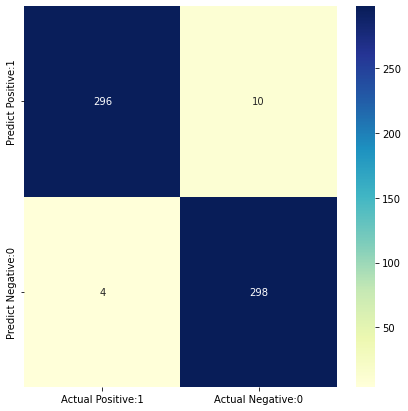

In [64]:
# predict using cv
y_pred = cross_val_predict(best_grid, X_comb, y, cv=kfold)

# generate cm
generate_confusion_matrix(y=y, y_pred=y_pred);

<a name="conclusions"></a>
# 4. Conclusions

1. As we can see __Logistic Regression__ does a pretty good job with a __mean f1_score of 89%__. 


2. __Random Forest__ without any tuning performs almost perfect with a __mean f1_Score of 97%__.


3. __Hyperparameter tuning__ using GS managed to increase the performance even more and raised the __mean f1_Score to over 99%__!